之前我给大家介绍过一篇使用keras和LSTM来进行文本多分类的博客 ,今天我将在google提供的Colab notebook上使用tensorflow2.0来是实现以下中文文本多分类的实战应用。选择Colab notebook是因为在Colab notebook中google提供了免费的GPU资源供你使用，这样可以大大节省模型的训练时间。

Google Colab，全名Colaboratory，是由谷歌提供的免费的云平台，可以使用keras、tensorflow等框架进行深度学习。最近Colab平台已经将K80 GPU更换成Tesla T4 GPU，提供了更强的算力。对于刚入门机器学习或深度学习的用户，这个平台是不二之选。

要使用Google Colab必须要在科学上网的环境下，同时必须要有一个gmail账号，还没有gmail账号的同学请赶快注册一个吧。

如何使用colab请看这篇博客（https://www.cnblogs.com/lfri/p/10471852.html）


In [1]:
# %matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import jieba as jb
import re

In [2]:
#如果还没有安装tensorflow2.0,请使用下面的命令安装tensorflow
#!pip install tensorflow==2.0.0

# 数据

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.6.0


In [6]:
df = pd.read_csv('./data/online_shopping_10_cats.csv')
print("数据总量: %d ." % len(df))
df.sample(10)

数据总量: 62774 .


,cat,label,review
46843,衣服,0,和图片还是有差距的
54766,酒店,1,住过这么多酒店，还是头一次碰到盖黄色的被子，感觉不干净；地毯是黑花的，感觉很脏乱。环境还好，...
21964,水果,0,苹果个头小，不如菜市场，就是有个包装，不建议自己买来食用
57479,酒店,1,已经住过几次这家酒店，感觉非常好。服务员态度友善，又够专业，客房的装设时尚、舒适，配套设施齐...
32317,洗发水,0,货是收到了，怎么会是多半瓶呢，难怪便宜，原来东西也少，京东以后也不能相信了
46302,衣服,0,我在京东买了自己都记不清多少次的东西，这一次也是我唯一网购给的差评，衣服收到很硬我想着我洗一...
14661,手机,1,待机时间长，声音够大。信号不错。
54414,酒店,1,"以住宿来说, 是一个不错的选择, 不过餐饮选择不多。地点不好找,也比较偏, 自己开车会方便点..."
3661,书籍,0,充满了惨不忍睹的比喻 例如：用掺着血的牙膏沫子形容一串粉红色珍珠的色泽 让人情何以堪？！
6745,平板,1,给服装店买的两个，应该还不错。


In [8]:
df[["cat"]].drop_duplicates().reset_index(drop=True)

,cat
0,书籍
1,平板
2,手机
3,水果
4,洗发水
5,热水器
6,蒙牛
7,衣服
8,计算机
9,酒店


In [9]:
print(df.cat.value_counts())
print()
print(df.cat.value_counts()/len(df));


平板     10000
水果     10000
洗发水    10000
衣服     10000
酒店     10000
计算机     3992
书籍      3851
手机      2323
蒙牛      2033
热水器      575
Name: cat, dtype: int64

平板     0.159302
水果     0.159302
洗发水    0.159302
衣服     0.159302
酒店     0.159302
计算机    0.063593
书籍     0.061347
手机     0.037006
蒙牛     0.032386
热水器    0.009160
Name: cat, dtype: float64


In [10]:
df[df.cat=='平板'][["review"]].sample(5).values

array([['分辨率太低！到手存储空间不到4个G了！'],
       ['一直想入一个国产平板，挑了很久看好了荣耀畅玩平板2，买的9.6大屏，看起来真心爽。配置完全够用！分屏功能尤其好评！'],
       ['颜色大气高端，速度很快，清晰度好高，物流服务很好，绝对物有所值。'],
       ['外观很漂亮，买个妈用的，大屏不怕看不清了，看电视剧更方便'],
       ['现在用着还没有什么毛病，感觉还不错，不卡。']], dtype=object)

In [11]:
df[df.cat=='手机'][["review"]].sample(5).values

array([['1.自动开关机功能。我最喜欢的手机功能，M330居然有，我太兴奋了。设定自动开关机，在一定程度上可以延长手机待机时间，爽。2.红外线功能。M330如此价位的机器，居然有红外，且红外兼容性还不错，可以和部分有红外的手机通过红外传图片（不能传铃声），但通过红外传电脑上的图铃至M330没有任何问题。3.通话计时提示音功能。这个功能很人性化，拿到M330时，进入“通话记录-通话计时-提示设置”，发现只能设置分钟，有些失望。可设置为1分时，发现实际通话时是每到50秒就有提示音（提示音还比较大声），欣喜若狂。（后来看了说明书，知道提示音是在设置分钟数前10秒就发音提示的）4.其他人性化的方面。M330内置了不少实用功能，如录音器（录音最长达120秒）/日历/货币转换，这些功能平时生活中都用得着。M330的背景灯亮度可以调节，屏幕对比度可以调节，让人觉得用起很舒心。M330打游戏和GPRS上网时，屏幕背景灯常亮，很为用户着想。M330的左右功能键可以自己编辑，很方便。'],
       ['按键比较独特，设计新颖，手感舒服'],
       ['内屏材质为STN，不及主流的TFT！铃声音色不好，高音时还有失真现象！不支持MP3播放器！机身内存小，只有1.5MB！短信容量小，只有50条！短信不支持群发！电话簿项目少！'],
       ['全是缺点，这是我切身体会'],
       ['VK900手机各方面操作可以.比较人性化.照像比较好,像这样价格的手机,有这样的性能,我还是比较满足了.MP3用起来还可以.声音比较清楚.']],
      dtype=object)

In [12]:
df[df.cat=='酒店'][["review"]].sample(5).values

array([['还不错的酒店，虽然有些旧，日方也撤资了。可能南京本来也不大的原因吧，从酒店去新街口等地方都不远。服务也很好。'],
       ['我们一家三口在岛上住了一天,总的感觉还不错.沙滩海水无得弹,很多珊湖石.在携程订观海木楼,山下几间房是看不到海的,一定要山上的才能观到海,有点遗憾.在岛上吃得还能接受,就是什么都要现金,另外晚上有很多小动物.'],
       ['酒店位置离市中心很近,很方便.酒店硬件设施也不错,.'],
       ['我真的建议所有到成都出差的朋友千万不要入住这家酒店，首先这个酒店的位置实在不好，附近基本上没有什么娱乐，而且因为附近的出租车是属于郊区的，管理非常不严格，如果发现不是本地人就会绕很远的路，我为了离客户的近才住的这家酒店，结果10元的路程，出租车竟然给我绕了30元。最重要的是这个酒店的服务很差，行政房没有行政待遇，check out时候竟然把免费的服务都算钱了。而且我是洲际的金卡会员，一向比较重视积分的和住宿天数的累计，因为我是携程定的酒店，这家酒店竟然不给我积分，甚至连一个标准的会员入住天数也没有给我累积。同样的在成都总府路附近的洲际下属的总府皇冠酒店，服务和地理环境非常的好，而且明确告诉我虽然是携成订的，但是优悦会的会员卡照样积分，这里说明一下，因为第一天住的不满意，我第二天就搬到那边了。我真心的建议所有有优悦会会员卡的朋友一定不要住这个酒店，要住就去总府皇冠，而且成都很小，高新开发区离市中心也不是很远，住在总府也方便的。'],
       ['比较值，房间东东都比较新。主要是政府人员在此活动。商品部非常贵－－有点宰人！']], dtype=object)

In [13]:
df[df.cat=='衣服'][["review"]].sample(5).values

array([['快递很快，卖家服务热情，裤子质量很好哦，拍的薄款夏天穿太合适了'],
       ['看着感觉一般般，没图片好看！'],
       ['宝贝收到了，老公非常喜欢，穿着很合身，样式好看，他喜欢我就很满意噢！必须好评！'],
       ['东西不错，质量好，就是有点儿大了。下次买小一码的。'],
       ['东西到了，与店家谈好的两件一起发货只看到一件 物流速度也超慢 要退货了才到货 真是无语了。']], dtype=object)

## 数据预处理

下面我们要对评语进行一些预处理工作,这包括删除文本中的标点符号,特殊符号,还要删除一些无意义的常用词(stopword),因为这些词和符号对系统分析预测文本的内容没有任何帮助,反而会增加计算的复杂度和增加系统开销,所有在使用这些文本数据之前必须要将它们清理干净。

In [15]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

#加载停用词
stopwords = stopwordslist("./data/chineseStopWords.txt")

中文停用词包含了很多日常使用频率很高的常用词,如 吧，吗，呢，啥等一些感叹词等,这些高频常用词无法反应出文本的主要意思,所以要被过滤掉。


In [16]:
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

,cat,label,review,clean_review
48789,计算机,1,外观，键盘，性能和电池都挺不错，但就是进不了系统，郁闷啊。硬盘嘎吱响，怀疑有问题。虽然楼上有...,外观键盘性能和电池都挺不错但就是进不了系统郁闷啊硬盘嘎吱响怀疑有问题虽然楼上有人讲F9导入系...
51744,计算机,0,耳机、USB在右手下方位置，影响操作鼠标；12寸宽屏字体相对小一些；没有光驱。,耳机USB在右手下方位置影响操作鼠标12寸宽屏字体相对小一些没有光驱
2492,书籍,0,"幸亏只买了一 本,也只浪费几元钱,我觉得中国人一直很喜欢一窝蜂的看待一些事物,没有自己主观的...",幸亏只买了一本也只浪费几元钱我觉得中国人一直很喜欢一窝蜂的看待一些事物没有自己主观的判断这本...
36935,蒙牛,1,我发现自己喜欢奶类的饮料。比如、旺仔，哇哈哈，蒙牛，果粒奶优。这是什么状况？没有长大？不至于。,我发现自己喜欢奶类的饮料比如旺仔哇哈哈蒙牛果粒奶优这是什么状况没有长大不至于
28366,洗发水,1,沙宣的确实不错，非常好用，赶上打折，性价比很高,沙宣的确实不错非常好用赶上打折性价比很高
15490,手机,0,e398视频不能放，售后说是软件版本的事，已有好多用户放映了,e398视频不能放售后说是软件版本的事已有好多用户放映了
1782,书籍,1,此书堪称经典。无论是否研究历史，无论是否爱好历史，甚至无论是否了解哪怕一丁点历史，都应该看看...,此书堪称经典无论是否研究历史无论是否爱好历史甚至无论是否了解哪怕一丁点历史都应该看看这本书通...
29995,洗发水,1,6.18活动买的，感觉超值，等用用再追加评价吧。,618活动买的感觉超值等用用再追加评价吧
44203,衣服,0,穿起来不舒服手工太粗糙,穿起来不舒服手工太粗糙
8703,平板,1,还可以吧 买贵了 第二天降价了 申请补差价 很顺利就退钱了,还可以吧买贵了第二天降价了申请补差价很顺利就退钱了


我们过滤掉了review中的标点符号和一些特殊符号，并生成了一个新的字段 clean_review。接下来我们要在clean_review的基础上进行分词,把每个评论内容分成由空格隔开的一个一个单独的词语。

In [17]:
#分词，并过滤停用词
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/xp/xrb2_xtx55g6g2wxnjw01wgr0000gn/T/jieba.cache
Loading model cost 1.389 seconds.
Prefix dict has been built successfully.


,cat,label,review,clean_review,cut_review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜血液 保持 一颗 年轻 ...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,作者 真有 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 不深 仍然 感受...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,作者 长篇大论 借用 详细 报告 数据处理 工作 计算结果 支持 其新 观点 荷兰 曾经 县...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,作者 战 之前 拥抱 令人 叫绝 日本 没有 战败 会 美军 占领 没胡 官僚主义 延续 没...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,作者 少年 时即 喜 阅读 看出 精读 无数 经典 一个 庞大 内心世界 作品 难能可贵 两...


# 建模

 首先我们要数据集中拆分出训练集和验证集,我们将80%的数据作为训练集,20%的数据作为验证集，我们通过分层抽样的方式来随机抽样，注意在这里我们使用了sklearn的train_test_split的方法来抽样,并使用了stratify参数来保证抽样后,训练集和验证集中的各个类目的占比与原数据集保持一致。

In [18]:
#拆分训练集和测试集
X_train, X_validation, Y_train, Y_validation = train_test_split(df[['cut_review']],df[["cat"]], test_size = 0.2,stratify=df.cat)
print(len(X_train))
print(len(X_validation))

50219
12555


In [19]:
Y_train.cat.value_counts()/len(Y_train)

水果     0.159302
洗发水    0.159302
酒店     0.159302
衣服     0.159302
平板     0.159302
计算机    0.063601
书籍     0.061351
手机     0.036998
蒙牛     0.032378
热水器    0.009160
Name: cat, dtype: float64

In [20]:
Y_validation.cat.value_counts()/len(Y_validation)

平板     0.159299
水果     0.159299
洗发水    0.159299
衣服     0.159299
酒店     0.159299
计算机    0.063560
书籍     0.061330
手机     0.037037
蒙牛     0.032417
热水器    0.009160
Name: cat, dtype: float64

In [21]:

vocab_size = 5000
embedding_dim = 64
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [22]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.cut_review.values)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [23]:
print(len(list(word_index.items())))
print()
list(word_index.items())[:10]

62617



[('<OOV>', 1),
 ('买', 2),
 ('不错', 3),
 ('没有', 4),
 ('酒店', 5),
 ('京东', 6),
 ('说', 7),
 ('房间', 8),
 ('非常', 9),
 ('一个', 10)]

In [24]:
X_train_sequences = tokenizer.texts_to_sequences(X_train.cut_review.values)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_validation_sequences = tokenizer.texts_to_sequences(X_validation.cut_review.values)
X_validation_padded = pad_sequences(X_validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [25]:
index = 10 
print(X_train.cut_review.values[index])
print()
print(X_train_sequences[index])
print()
X_train_padded[index]


口感 不错 说 无蜡 貌似 上面 蜡

[337, 3, 7, 1, 1502, 417, 4398]



array([ 337,    3,    7,    1, 1502,  417, 4398,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [26]:
print("104 ->",reverse_word_index[104])
print("3 ->",reverse_word_index[3])
print("120 ->",reverse_word_index[120])
print()
print("贴身 ->",dict(list(word_index.items()))["贴身"])
print("1 ->",reverse_word_index[1])


104 -> 携程
3 -> 不错
120 -> 环境

贴身 -> 7274
1 -> <OOV>


In [27]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.cat.values)

Y_training_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_train.cat.values))
Y_validation_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_validation.cat.values))

label_word_index = label_tokenizer.word_index

print(dict(list(label_word_index.items())))
print(Y_training_cat_seq.shape)
print()
print(Y_training_cat_seq[0])
print(Y_training_cat_seq[1])
print(Y_training_cat_seq[2])


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
(50219, 1)

[2]
[3]
[3]


In [28]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train_padded[0]))
print('------------------------------------------------')
print(X_train.cut_review.values[0])

水果 新鲜 重点 评价 一下 快递 小哥 服务态度 非常 非常 细心 水果 送到 够 面 一个 一个 检查 有没有 坏 感动 京东 配送 员 真的 非常 眼光 赞赞赞 ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
------------------------------------------------
水果 新鲜 重点 评价 一下 快递 小哥 服务态度 非常 非常 细心 水果 送到 够 面 一个 一个 检查 有没有 坏 感动 京东 配送 员 真的 非常 眼光 赞赞赞


In [29]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

2021-08-17 10:21:17.406088: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                715       
Total params: 395,019
Trainable params: 395,019
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
num_epochs = 10
history = model.fit(X_train_padded, 
                    Y_training_cat_seq, 
                    epochs=num_epochs, 
                    validation_data=(X_validation_padded, Y_validation_cat_seq), 
                    verbose=2)

2021-08-17 10:21:29.556191: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1570/1570 - 213s - loss: 0.6551 - accuracy: 0.7752 - val_loss: 0.3627 - val_accuracy: 0.8740
Epoch 2/10
1570/1570 - 185s - loss: 0.3069 - accuracy: 0.8940 - val_loss: 0.3663 - val_accuracy: 0.8757
Epoch 3/10
1570/1570 - 183s - loss: 0.2533 - accuracy: 0.9106 - val_loss: 0.3425 - val_accuracy: 0.8832
Epoch 4/10
1570/1570 - 189s - loss: 0.2228 - accuracy: 0.9208 - val_loss: 0.3524 - val_accuracy: 0.8802
Epoch 5/10
1570/1570 - 163s - loss: 0.1982 - accuracy: 0.9301 - val_loss: 0.3729 - val_accuracy: 0.8774
Epoch 6/10
1570/1570 - 200s - loss: 0.1800 - accuracy: 0.9354 - val_loss: 0.3802 - val_accuracy: 0.8792
Epoch 7/10
1570/1570 - 226s - loss: 0.1648 - accuracy: 0.9404 - val_loss: 0.3919 - val_accuracy: 0.8805
Epoch 8/10
1570/1570 - 234s - loss: 0.1483 - accuracy: 0.9460 - val_loss: 0.4461 - val_accuracy: 0.8729
Epoch 9/10
1570/1570 - 174s - loss: 0.1365 - accuracy: 0.9509 - val_loss: 0.4620 - val_accuracy: 0.8739
Epoch 10/10
1570/1570 - 171s - loss: 0.1233 - accuracy: 0.9555 -

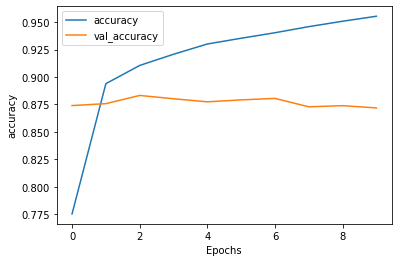

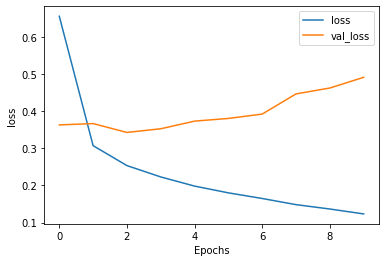

In [32]:
def plot_graphs(history, string):    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [33]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
 
y_pred = model.predict(X_validation_padded)
y_pred = y_pred.argmax(axis = 1)


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}


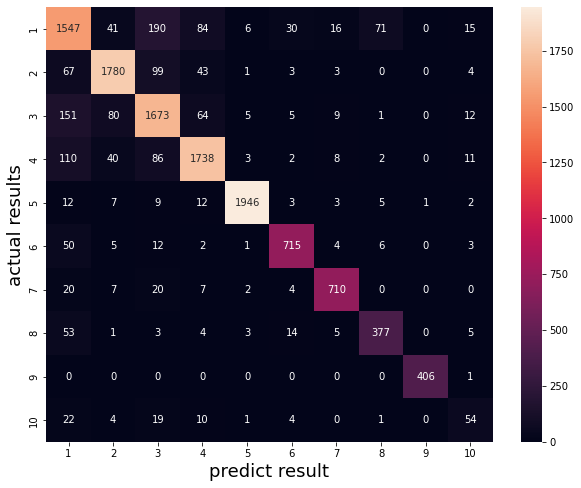

In [34]:
labels=[1,2,3,4,5,6,7,8,9,10] 
conf_mat = confusion_matrix(Y_validation_cat_seq, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel('actual results',fontsize=18);
plt.xlabel('predict result',fontsize=18);
print(dict(list(label_word_index.items())))



In [35]:
from  sklearn.metrics import classification_report 
print('accuracy %s' % accuracy_score(y_pred, Y_validation_cat_seq))
print(classification_report(Y_validation_cat_seq, y_pred,target_names=[str(w) for w in labels]))
print(dict(list(label_word_index.items())))

accuracy 0.8718438868976504
              precision    recall  f1-score   support

           1       0.76      0.77      0.77      2000
           2       0.91      0.89      0.90      2000
           3       0.79      0.84      0.81      2000
           4       0.88      0.87      0.88      2000
           5       0.99      0.97      0.98      2000
           6       0.92      0.90      0.91       798
           7       0.94      0.92      0.93       770
           8       0.81      0.81      0.81       465
           9       1.00      1.00      1.00       407
          10       0.50      0.47      0.49       115

    accuracy                           0.87     12555
   macro avg       0.85      0.84      0.85     12555
weighted avg       0.87      0.87      0.87     12555

{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
